# Financial Risk Prediction Pipeline

This notebook implements a financial risk prediction model using various machine learning techniques, with data sourced from a Data Warehouse and processed for binary classification.


#### 1. **Libraries and Setup**

- Utilizes popular Python libraries such as `numpy`, `pandas`, `matplotlib`, and `seaborn` for data manipulation and visualization.
- Machine learning models are built using `scikit-learn` (`RandomForestClassifier` and `XGBClassifier`).
- The environment variables for database access are managed using `dotenv`, and SQL connection is handled via `SQLAlchemy`.


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import ppscore as pps
# SQL Connection Libraries
import sqlalchemy
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

#### **Data Loading and Preprocessing**

#### 2. Load environment variables and establish a connection to the Data Warehouse


In [ ]:
load_dotenv()

MYSQL_USERNAME = os.getenv('MYSQL_USERNAME')
MYSQL_PASSWORD = os.getenv('MYSQL_PASSWORD')
MYSQL_HOST = os.getenv('MYSQL_HOST')
MYSQL_PORT = os.getenv('MYSQL_PORT')
MYSQL_DB = os.getenv('DATA_WAREHOUSE_DB')

# Create a database connection
if MYSQL_PASSWORD:
    connection_string = f"mysql+pymysql://{MYSQL_USERNAME}:{MYSQL_PASSWORD}@{MYSQL_HOST}:{MYSQL_PORT}/{MYSQL_DB}"
else:
    connection_string = f"mysql+pymysql://{MYSQL_USERNAME}@{MYSQL_HOST}:{MYSQL_PORT}/{MYSQL_DB}"

engine = create_engine(connection_string)
print('Connection to MySQL database established successfully.')

#### 3. Load relevant tables from the Data Warehouse into pandas DataFrames


In [ ]:
company_df = pd.read_sql('SELECT * FROM Dim_Company', engine)
financial_df = pd.read_sql('SELECT * FROM Fact_Financial_Performance', engine)

#### 4. Data Preparation

In [ ]:
# Merging company, financial, date, industry, and state data for analysis
data_df = financial_df.merge(company_df, on='company_id', how='left')

# Create a binary target variable: 1 if 'bankrupt' indicates risk, 0 otherwise
data_df['target'] = data_df['bankrupt'].apply(lambda x: 1 if x == 'bankrupt' else 0)

# Drop unnecessary columns
drop_columns = ['performance_id', 'company_id', 'date_id', 'industry_id', 'state_id', 'bankrupt']
data_df.drop(columns=drop_columns, inplace=True, errors='ignore')

#We don't have null or none numeric values, the data warehouse is well maintained
# we''ll keep the code for future use

# Handle missing values
# numeric_cols = data_df.select_dtypes(include=['float64', 'int64']).columns

# data_df[numeric_cols] = data_df[numeric_cols].fillna(data_df[numeric_cols].median())
# data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# data_df.fillna(data_df.median(), inplace=True)

#### 5. EDA for the ML model


The necessary EDA for our use case is performed to understand the data distribution and relationships between features.

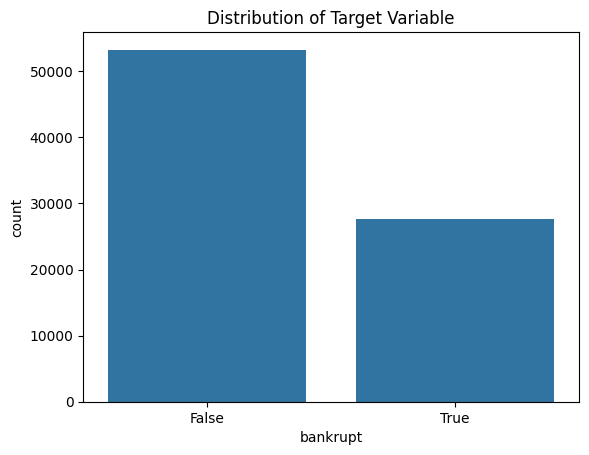

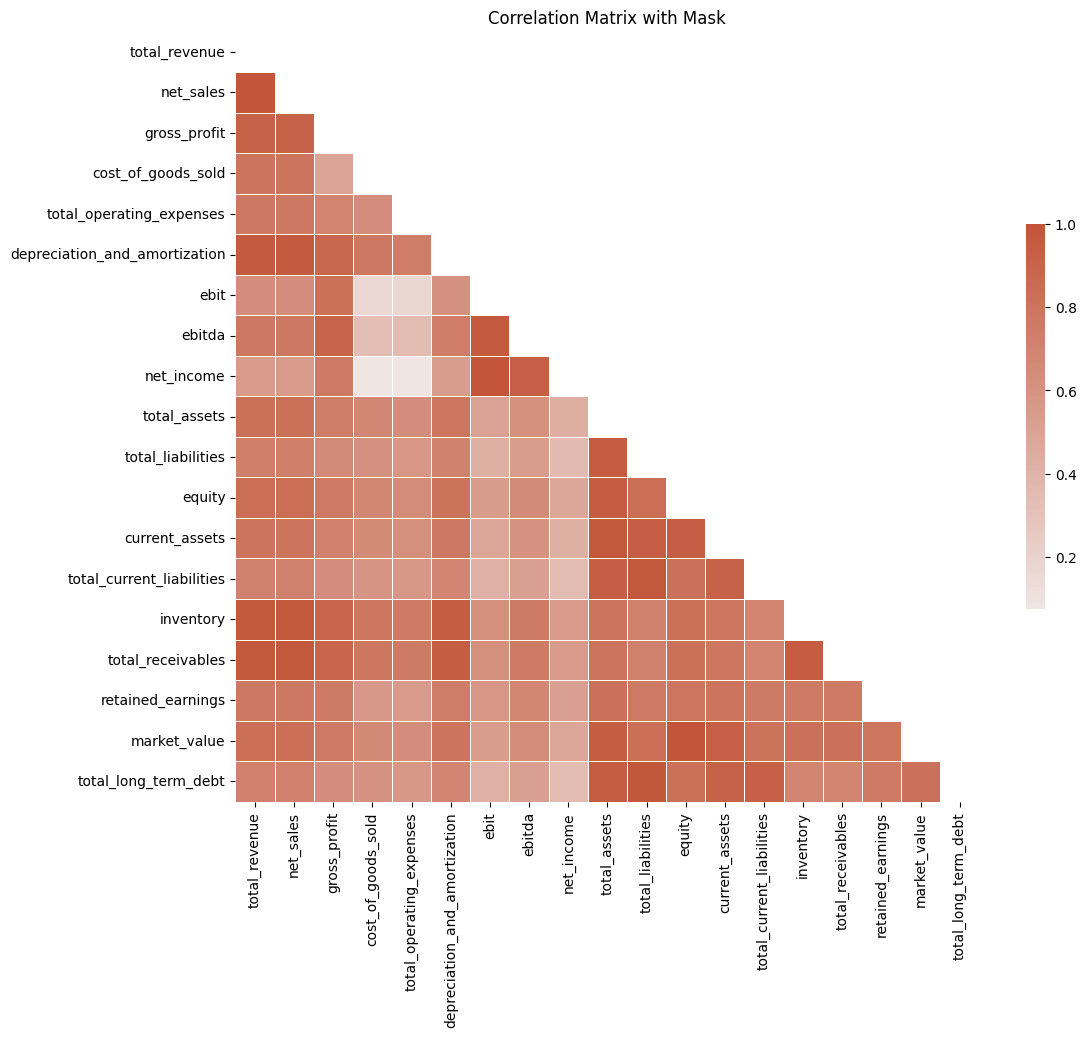

In [56]:
# Check the distribution of the target variable
sns.countplot(x='bankrupt', data=data_df)
plt.title('Distribution of Target Variable')
plt.show()

# Correlation matrix
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Matrix with Mask")
plt.show()


#### 6. Feature Selection Using Predictive Power Score (PPS)

In [61]:
data_df.rename(columns={'bankrupt': 'target'}, inplace=True)

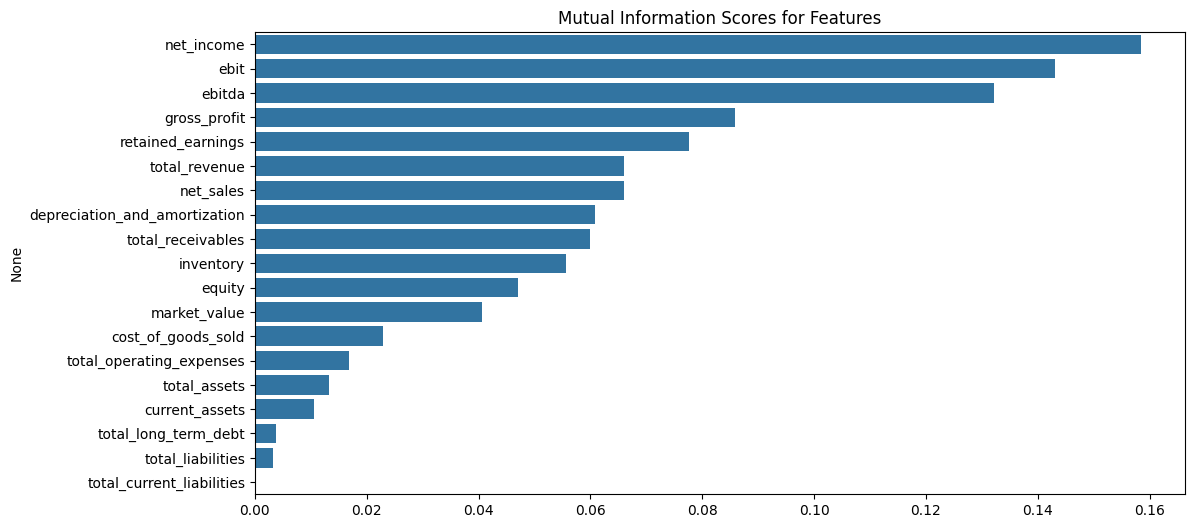

Selected features based on Mutual Information: ['net_income', 'ebit', 'ebitda']


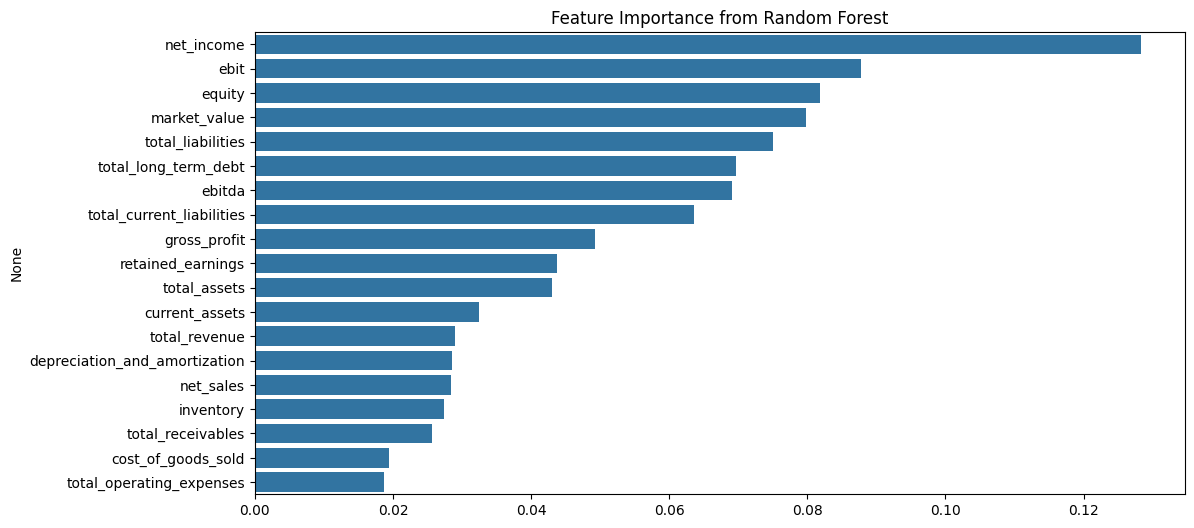

Selected features based on Random Forest importance: ['net_income', 'ebit', 'equity', 'market_value', 'total_liabilities', 'total_long_term_debt', 'ebitda', 'total_current_liabilities']
Final selected features: ['total_current_liabilities', 'market_value', 'total_long_term_debt', 'net_income', 'total_liabilities', 'ebit', 'ebitda', 'equity']


In [65]:
# Calculate Mutual Information for Feature Selection
mi_scores = mutual_info_classif(data_sample.drop(columns=['target']), data_sample['target'])
mi_scores_series = pd.Series(mi_scores, index=data_sample.drop(columns=['target']).columns).sort_values(ascending=False)

# Plot Mutual Information Scores
plt.figure(figsize=(12, 6))
sns.barplot(x=mi_scores_series.values, y=mi_scores_series.index)
plt.title('Mutual Information Scores for Features')
plt.show()

# Selecting features with high MI scores (custom threshold, adjust as needed)
threshold_mi = 0.1
selected_features_mi = mi_scores_series[mi_scores_series > threshold_mi].index.tolist()

print(f"Selected features based on Mutual Information: {selected_features_mi}")

# Using RandomForest to Get Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(data_sample.drop(columns=['target']), data_sample['target'])

# Get feature importance from RandomForest
feature_importances = rf.feature_importances_
rf_feature_importances_series = pd.Series(feature_importances, index=data_sample.drop(columns=['target']).columns).sort_values(ascending=False)

# Plot Feature Importance from RandomForest
plt.figure(figsize=(12, 6))
sns.barplot(x=rf_feature_importances_series.values, y=rf_feature_importances_series.index)
plt.title('Feature Importance from Random Forest')
plt.show()

# Selecting features with high importance (custom threshold, adjust as needed)
threshold_rf = 0.05
selected_features_rf = rf_feature_importances_series[rf_feature_importances_series > threshold_rf].index.tolist()

print(f"Selected features based on Random Forest importance: {selected_features_rf}")

# Combine selected features from both MI and RandomForest
selected_features = list(set(selected_features_mi + selected_features_rf))

print(f"Final selected features: {selected_features}")


#### 7. Splitting Data and Feature Scaling

In [66]:
# Splitting data into training and testing sets
X =data_sample[selected_features]
y =data_sample['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scaling features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### 8. Predictive Power Score (PPS) Analysis

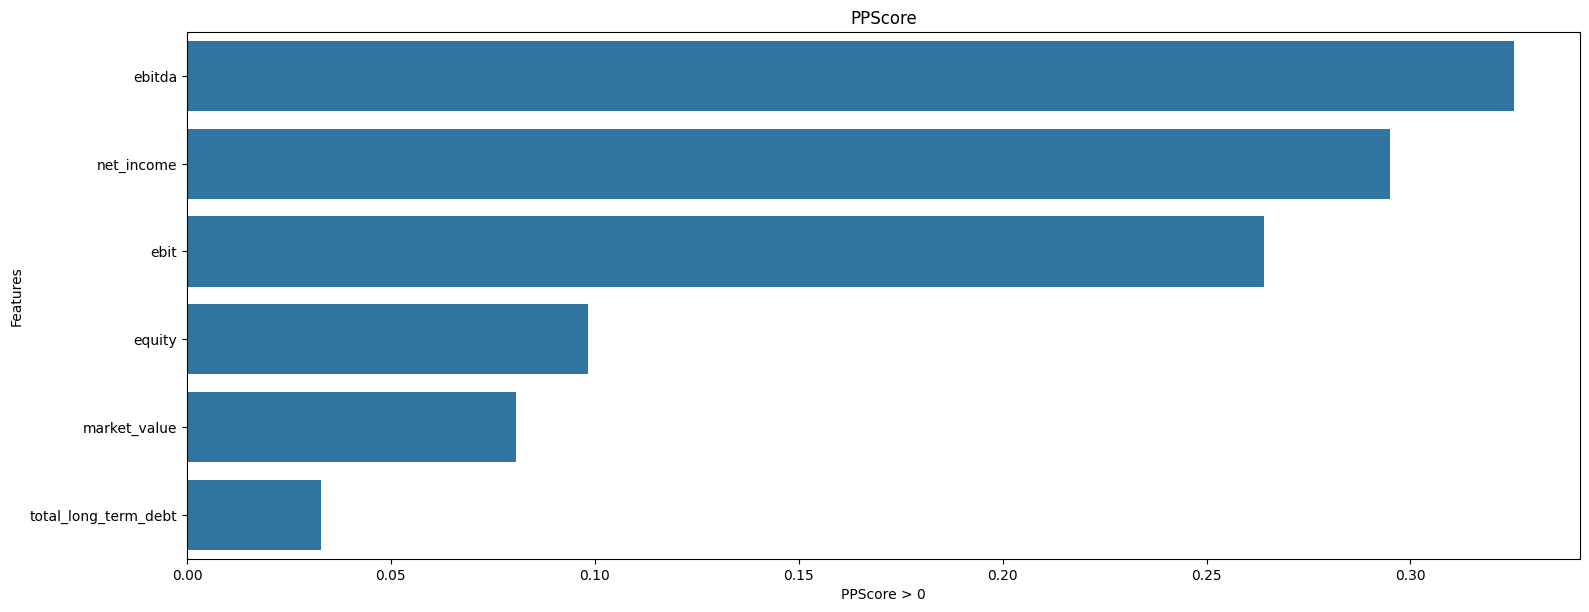

In [67]:
# Calculating Predictive power score (PPS)
pps_input_df = X_train.copy()
pps_input_df['Bankrupt'] = y_train.astype(str).copy()
pps_df = pps.predictors(pps_input_df, y="Bankrupt")
pps_df = pps_df[pps_df.ppscore > 0]

# Plotting PPS
plt.figure(figsize=(16,6))
sns.barplot(data=pps_df, x="ppscore", y="x")
plt.ylabel("Features")
plt.xlabel("PPScore > 0")
plt.tight_layout()
plt.title("PPScore")
plt.show()

#### 9. Model Training and Hyperparameter Tuning


In [69]:
# Train both Random Forest and XGBoost models and use RandomizedSearchCV for hyperparameter tuning
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)  # Adding XGBoost classifier

param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.3, 0.7, 1.0]
}

# Random Forest search
random_search_rf = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist_rf, n_iter=50, cv=5, scoring='f1', random_state=42, n_jobs=-1)
random_search_rf.fit(X_train_scaled, y_train)
best_rf = random_search_rf.best_estimator_

# XGBoost search
random_search_xgb = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_dist_xgb, n_iter=50, cv=5, scoring='f1', random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train_scaled, y_train)
best_xgb = random_search_xgb.best_estimator_


#### 10. Model Evaluation

In [70]:
# Define performance metrics and evaluate model performance on training and test data
def perf_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {'accuracy': round(accuracy*100, 2), 'precision': round(precision*100, 2), 'recall': round(recall*100, 2), 'f1_score': round(f1*100, 2)}

# Evaluate Random Forest
y_train_pred_rf = best_rf.predict(X_train_scaled)
y_test_pred_rf = best_rf.predict(X_test_scaled)
train_metrics_rf = perf_metrics(y_train, y_train_pred_rf)
test_metrics_rf = perf_metrics(y_test, y_test_pred_rf)

# Evaluate XGBoost
y_train_pred_xgb = best_xgb.predict(X_train_scaled)
y_test_pred_xgb = best_xgb.predict(X_test_scaled)
train_metrics_xgb = perf_metrics(y_train, y_train_pred_xgb)
test_metrics_xgb = perf_metrics(y_test, y_test_pred_xgb)

print("Random Forest - Training Performance:", train_metrics_rf)
print("Random Forest - Test Performance:", test_metrics_rf)
print("XGBoost - Training Performance:", train_metrics_xgb)
print("XGBoost - Test Performance:", test_metrics_xgb)


#### 11. Feature Importance

In [ ]:
# Plot the feature importance for the Random Forest model
feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': best_rf.feature_importances_})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

top_n_feat = 7
# Get best decision tree model
best_dt_classifier = random_search.best_estimator_

# Extract feature importances from the trained decision tree classifier
feature_importances = best_dt_classifier.feature_importances_
feature_names = best_dt_classifier.feature_names_in_

# Get the indices of the top n features
top_n_indices = np.argsort(feature_importances)[-top_n_req:]

# Create a DataFrame for easier plotting with seaborn
feature_importance_df = pd.DataFrame({'Feature': [feature_names[i] for i in top_n_indices],
                                      'Importance': feature_importances[top_n_indices]})

# Plot the top 10 features using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel("Feature Importance")
plt.title("Top "+str(top_n_feat)+" Feature Importance")
plt.show()

#### 12. Model Interpretation Using SHAP and LIME


In [ ]:
# Use SHAP to interpret Random Forest predictions
explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_rf.shap_values(X_test_scaled)
shap.summary_plot(shap_values_rf[1], X_test_scaled, feature_names=selected_features)

# Use SHAP to interpret XGBoost predictions
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)
shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=selected_features)

#  leaving this here as a reminder to do some research about it later
# lime_explainer = LimeTabularExplainer(X_train_scaled, training_labels=y_train, feature_names=selected_features)
